# Implementation of vCC

The following is VQE code using the scipy.optimize.minimize in the classical optimisation loop, and the vCC ansatz that uses lcu and fpoaa functions from _vcc_lcu for state preparation.

In [1]:
import numpy as np                          # for rank_1_projector and other custom matrices
import math
import matplotlib.pyplot as plt
from collections import Counter

from projectq import MainEngine
from projectq.ops import H, Ry, Rx, X, Y, Z, R, Ph, All, Measure, ControlledGate
                                            # Ph for global phase
                                            # R is for phase gates
from projectq.ops._basics import SelfInverseGate
                                            # because they don't have a named identity
        
from projectq.meta import Dagger, Compute, Uncompute, Control

from projectq.ops import QubitOperator
from openfermion.ops import FermionOperator

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner

from _vcc_lcu import *

In [2]:
def my_jordan_wigner(fermion_op):
    qubit_op = jordan_wigner(fermion_op)
    good_qop = QubitOperator()
    for term in qubit_op.terms:
        good_qop += QubitOperator(term, qubit_op.terms[term])
    return good_qop


def cc_quantum_coprocessor(theta, *ccargs):
    """
    Arguments:
        theta (float): variational parameters for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the trial wavefunction for parameter theta
    """
    eng = MainEngine()
    # unpack arguments
    hamiltonian = ccargs[0]
    n_orbitals = ccargs[1]
    n_electrons = ccargs[2]

#     print('\n The hamiltonian they gave me is:\n')
#     print(hamiltonian)
    
    n_unocc = n_orbitals - n_electrons
    
    unocc = eng.allocate_qureg(n_unocc)
    occ = eng.allocate_qureg(n_electrons)
    cc_trial = occ+unocc
    # operator for making Hartree-Fock initial state |00...01...1>
    hf_str = tuple((index, 'X') for
                              index in range(n_unocc))
    hf_init_op = QubitOperator(hf_str, 1.0)
#     print(hf_init_op)
    
    # Allocate LCU control reg - depends on excitation order trunc
    trunc = 2
    ctrl_dim = 2*trunc + 1
    ctrl = eng.allocate_qureg(ctrl_dim)
    # the lcu algo takes the state [ctrl|occ|unocc]
    cc_lcu = ctrl+cc_trial
                
    # unpack CC amplitudes 
    n_sings = n_orbitals*n_orbitals
    n_doubs = n_sings*n_sings
    single_amps = theta[:n_sings].reshape(n_orbitals,n_orbitals)
    double_amps = theta[n_sings:].reshape(n_orbitals,n_orbitals,n_orbitals,n_orbitals)
    # save the max of all amps to determine fpoaa depth
    t_max = np.amax([abs(x) for x in theta])
    # and convert amps to lists of nonzeros, with indices, coeft, and number of time slices
    time_slicing_threshold = 0.05
    single_amps, double_amps = generate_term_list(
            single_amps, double_amps, time_slicing_threshold)
#     print('single amps:\n\t')
#     print(single_amps)
#     print('double amps:\n\t')
#     print(double_amps)
    # save number of nonzeros for later use
    n_terms = len(single_amps) + len(double_amps)
#     print('# singles = {} and # doubles = {}'.format(len(single_amps), len(double_amps)))
    
    # set success probability level for LCU steps, p_succ = 1-eps
    # eps in our method depends on the max number of 'time' slices 
    # and the total number of terms, as eps = 1/CrM
    # this give overall succ probability of the method as ~ (1/e)^1/C, in theory
    # C=5 gives p > 0.81
    C = 10
    r = np.amax([term[2] for term in single_amps+double_amps])
#     print('max_r = {}'.format(r))
    eps = 1.0/(C*r*n_terms)
#     print('eps = {}'.format(eps))
    
    # fpoaa depth k => 3^k = (log p_fail)/(log 2t_max)
    fpoaa_queries = math.log(eps, 10)/math.log(2*t_max, 10)
    if (fpoaa_queries>=3):
        fpoaa_depth = math.log(fpoaa_queries,3)
    else:
        fpoaa_depth = 0    
    
    # Apply lcu term by term, first all singles, then all doubles
    # Loop over this until success
    # start from top every time LCU+post fails
    done = False
    num_tarings = 0
    while(not done):
        # tare to all zeros state (when picking up from failed LCU)
        for i in range(0,n_orbitals+ctrl_dim):
            Measure | cc_lcu[i]
            if(bool(cc_lcu[i])):
                X | cc_lcu[i]
            num_tarings += 1
        # set unocc orbitals to 1 (0 = occ)
        hf_init_op | unocc
#         print("Amplitudes of CC_init state:\n")
#         print_amplitudes(eng, cc_lcu, n_orbitals+ctrl_dim)
        
        if not single_amps:
            done_singles = True
        for [i,j], t, r in single_amps:
            done_singles = False
            list_u = []
            i,j = sorted((i,j))
            op_str = str(j)+'^'+' '+str(i)
            fer_op = FermionOperator(op_str, 1.0)
            qub_op = QubitOperator('', 1.0) + my_jordan_wigner(fer_op)
            for term in qub_op.terms:
                coeft = qub_op.terms[term]/abs(qub_op.terms[term])
                list_u += [QubitOperator(term, coeft)]
            coefts = [0.25*t/r for x in range(4)]
            coefts = np.concatenate(([1.0], coefts))
#             print('\n LCU coefficients in singles term {}{}, and the lcu'.format(i, j))
#             print(coefts)
#             print(list_u)
            if not list_u:
                print('lcu in singles term {} is empty!!'.format(op_str))
            for i in range(0, r):
                lcu(eng, list_u, coefts, ctrl, cc_trial, ctrl_dim, n_orbitals, fpoaa_depth)
                eng.flush()
                done_singles = bool(postselect(ctrl, ctrl_dim))
                if not done_singles:
                    break

            if not done_singles:
                break

        if not done_singles: 
            continue
#         print('Finished singles...')
        
        if not double_amps:
            done_doubles = True
        for [i,j,k,l], t, r in double_amps:
            done_doubles = False
            list_u = []
            i,j,k,l = sorted([i,j,k,l])
            # make sure we're not trying to access a term where multiple indices are the same
            op_str = str(k)+'^'+' '+str(l)+'^'+' '+str(j)+' '+str(i)
            fer_op = FermionOperator(op_str, 1.0)
            qub_op = QubitOperator('', 1.0) + my_jordan_wigner(fer_op)
            for term in qub_op.terms:
                coeft = qub_op.terms[term]/abs(qub_op.terms[term])
                list_u += [QubitOperator(term, coeft)]
            coefts = [0.0625*t/r for x in range(16)]
            coefts = np.concatenate(([1.0], coefts))
            if not list_u:
                print('lcu in doubles term {} is empty!!'.format(op_str))
            for i in range(0, r):
                lcu(eng, list_u, coefts, ctrl, cc_trial, ctrl_dim, n_orbitals, fpoaa_depth)
                eng.flush()
                done_doubles = bool(postselect(ctrl, ctrl_dim))
                if not done_doubles:
                    break
            
            if not done_doubles:
                break
          
        done = done_doubles
#         if done:
#             print('Finished doubles...')
            
#     print('Had to repeat {} times'.format(num_tarings))
    # flush all gates
    eng.flush()
#     print("Amplitudes of CC_trial state:\n")
#     print_amplitudes(eng, cc_lcu, n_orbitals+ctrl_dim)
    # Calculate the energy.
    # ProjectQ simulator can directly return expectation values
    # In reality need to implement Hamiltonian averaging term-wise
    energy = eng.backend.get_expectation_value(hamiltonian, cc_trial)
#     print('Measured trial energy = {}'.format(energy))
    # Measure all to satisfy projectq simulator
    eng.flush()
    All(Measure) | cc_lcu
    eng.flush()
    return energy

/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])


H2_sto-3g_singlet_0.62 has vCCSD energy of -0.047924344180921064 Hartree at r=0.62.
H2_sto-3g_singlet_0.66 has vCCSD energy of -0.12354064072194704 Hartree at r=0.66.
H2_sto-3g_singlet_0.7 has vCCSD energy of -0.19149376498908388 Hartree at r=0.7.
H2_sto-3g_singlet_0.74 has vCCSD energy of -0.2524861977581867 Hartree at r=0.74.
H2_sto-3g_singlet_0.78 has vCCSD energy of -0.3072333301938458 Hartree at r=0.78.
H2_sto-3g_singlet_0.82 has vCCSD energy of -0.3564323098962032 Hartree at r=0.8200000000000001.
H2_sto-3g_singlet_0.86 has vCCSD energy of -0.4007368593181812 Hartree at r=0.86.
H2_sto-3g_singlet_0.9 has vCCSD energy of -0.4407396054757611 Hartree at r=0.9.


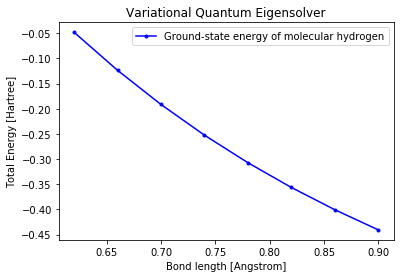

In [3]:
# %%capture printed_output
# capture output to object to display later
# so that notebook can be closed and then output seen later


from numpy import linspace
from scipy.optimize import minimize

# from openfermion/utils/_unitary_cc.py
def generate_term_list(single_amplitudes, double_amplitudes, threshold=0.05):
    """Re-format single_amplitudes and double_amplitudes from ndarrays to lists.
    Args:
        single_amplitudes(ndarray): [NxN] array storing single excitation
            amplitudes corresponding to t[i,j] * (a_i^\dagger a_j - H.C.)
        double_amplitudes(ndarray): [NxNxNxN] array storing double
            excitation amplitudes corresponding to
            t[i,j,k,l] * (a_i^\dagger a_j a_k^\dagger a_l - H.C.)
    Returns:
        single_amplitudes_list(list): list of lists with each sublist storing
            a list of indices followed by single excitation amplitudes,
            and number of time slices
            i.e. [[[i,j],t_ij, r_ij], ...]
        double_amplitudes_list(list): list of lists with each sublist storing
            a list of indices followed by double excitation amplitudes
            and number of time slices
            i.e. [[[i,j,k,l],t_ijkl, r_ijkl], ...]
    """
    single_amplitudes_list, double_amplitudes_list = [], []

    for i, j in zip(*single_amplitudes.nonzero()):
        if i==j:
            continue
        r = math.ceil(single_amplitudes[i, j]/threshold)
        if r <= 1:
            r=1           
        single_amplitudes_list.append([[i, j], single_amplitudes[i, j], r])

    for i, j, k, l in zip(*double_amplitudes.nonzero()):
        if (i==j) or (k==l) or (i==k) or (i==l) or (j==k) or(j==l):
            continue
        r = math.ceil(double_amplitudes[i, j, k, l]/threshold)
        if r <= 1:
            r=1
        double_amplitudes_list.append([[i, j, k, l],
                                      double_amplitudes[i, j, k, l], r])
    return single_amplitudes_list, double_amplitudes_list


def vqe_classical_processor(molecular_details, r_min, r_max, n_pts):
    
    """
    Read MolecularData from HDF5 output of OpenFermion-Psi4
    Populate bond_lengths, extract hamiltonian
    """    
    lowest_energies = []
    bond_lengths = linspace(r_min, r_max, n_pts)    
    
    folder = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/'
    
    for i in range(n_pts):
        file_i = folder + molecular_details + str(bond_lengths[i])

        # Load data from HDF5 computed using Openfermion-Psi4
        molecule = MolecularData(filename=file_i)
        n_orbs = molecule.n_qubits
        n_elec = molecule.n_electrons
#         print('# orbitals = {} and # electrons = {}'.format(n_orbs, n_elec))

        # Extract initial guesses for CCSD single and double amplitudes
        # stored as numpy arrays
        # 1) MolecularData not storing MP2 amplitudes.. 2) faster convergence 
        ccsd_single_init = molecule.ccsd_single_amps
        ccsd_double_init = molecule.ccsd_double_amps
#         ccsd_single_init = np.zeros((8,8))
#         ccsd_single_init = np.random.rand(8,8)
#         ccsd_single_init = np.multiply(ccsd_single_init, 0.01)
#         ccsd_double_init = np.zeros((8,8,8,8))
        theta_0 = np.hstack([ccsd_single_init.flatten(), ccsd_double_init.flatten()])

        # Convert hamiltonian to QubitOperator using JW
        molecule_qubit_hamiltonian = my_jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

        # Classical optimisation loop using scipy.optimize.minimize
        # for variational parameters theta (= CC amplitudes here)
        # Can pass different scipy optimizer options: Brent, Golden, Bounded
#         cc_quantum_coprocessor(theta_0, molecule_qubit_hamiltonian, n_orbs, n_elec)
        minimum = minimize(cc_quantum_coprocessor, theta_0,
                           args=(molecule_qubit_hamiltonian, n_orbs, n_elec)) # , method='Nelder-Mead'
        lowest_energies.append(minimum.fun)
        lowest_energies[i] -= molecule.nuclear_repulsion
        print('{} has vCCSD energy of {} Hartree at r={}.'.format(molecule.name, lowest_energies[i], bond_lengths[i]))
    
    # plot results of VQE calculation
    plt.xlabel("Bond length [Angstrom]")
    plt.ylabel("Total Energy [Hartree]")
    plt.title("Variational Quantum Eigensolver")
    plt.plot(bond_lengths, lowest_energies, "b.-",
             label="Ground-state energy of molecular hydrogen")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    molecular_details = 'H2_sto-3g_singlet_'
    r_min = 0.62
    r_max = 0.9
    n_pts = 8
    vqe_classical_processor(molecular_details, r_min, r_max, n_pts)


In [ ]:
printed_output.show()
